In [ ]:
# 프로젝트 클론
!git clone https://github.com/ultralytics/ultralytics.git

In [ ]:
# 라이브러리 설치
!pip install -q ultralytics

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

# CSV 파일 경로
train_csv_path = '/content/dacon_train.csv'
test_csv_path = '/content/dacon_test.csv'

# 이미지 저장 경로
train_img_dir = 'target_train_images'
test_img_dir = 'target_test_images'

# 디렉토리 생성 함수
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# 이미지 저장 함수
def save_images_from_csv(csv_path, img_dir, is_train=True):
    df = pd.read_csv(csv_path)

    # 필요한 디렉토리 생성
    if is_train:
        labels = df['label'].unique()
        for label in labels:
            make_dir(os.path.join(img_dir, label))
    else:
        make_dir(img_dir)

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        img_array = np.array(row.iloc[2:].values if is_train else row.iloc[1:].values, dtype=np.uint8).reshape(32, 32)
        img = Image.fromarray(img_array, mode='L')  # 'L' for grayscale

        if is_train:
            label = row['label']
            img_path = os.path.join(img_dir, label, f"{row['ID']}.png")
        else:
            img_path = os.path.join(img_dir, f"{row['ID']}.png")

        img.save(img_path)

# 실행
make_dir(train_img_dir)
make_dir(test_img_dir)

save_images_from_csv(train_csv_path, train_img_dir, is_train=True)
save_images_from_csv(test_csv_path, test_img_dir, is_train=False)


100%|██████████| 250/250 [00:00<00:00, 600.38it/s]


In [ ]:
import glob

train = glob.glob('/content/target_train_images/*/*.png')
test = glob.glob('/content/target_test_images/*.png')

In [ ]:
print(len(train))
print(len(test))

769
250


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 원본 데이터셋 폴더 경로
dataset_folder = "/content/target_train_images"

# 이동할 폴더 경로
train_folder = "/content/train"
val_folder = "/content/val"

# 클래스 폴더 목록 생성
class_folders = [folder for folder in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, folder))]

# 각 클래스 폴더의 데이터 이동
for class_folder in class_folders:
    class_folder_path = os.path.join(dataset_folder, class_folder)

    # 클래스 폴더 안의 파일 목록 가져오기
    file_list = os.listdir(class_folder_path)

    # 훈련 및 검증 데이터로 나누기
    train_files, val_files = train_test_split(file_list, test_size=0.2, random_state=2025)

    # 훈련 데이터를 train 폴더로 이동
    for file_name in train_files:
        src = os.path.join(class_folder_path, file_name)
        dst = os.path.join(train_folder, class_folder, file_name)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)

    # 검증 데이터를 val 폴더로 이동
    for file_name in val_files:
        src = os.path.join(class_folder_path, file_name)
        dst = os.path.join(val_folder, class_folder, file_name)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)


In [ ]:
# n : 현미경, s : 스마트폰, m/l/x, => coco dataset(80 class)
!yolo classify train data=/content/imoticon model=yolo11s-cls epochs=50

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 13.0M/13.0M [00:00<00:00, 349MB/s]
Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11s-cls, data=/content/imoticon, epochs=50, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, i

#test

In [ ]:
# 테스트 데이터셋 로드
test_df = pd.read_csv('/content/dacon_test.csv')

In [ ]:
# 커스텀 데이터 학습 모델 로드
from ultralytics import YOLO
model = YOLO('/content/runs/classify/train/weights/best.pt')

In [ ]:
# 학습 클래스명 확인
labels = model.names
labels

{0: 'airplane',
 1: 'apple',
 2: 'ball',
 3: 'bird',
 4: 'building',
 5: 'cat',
 6: 'emotion_face',
 7: 'police_car',
 8: 'rabbit',
 9: 'truck'}

In [ ]:
# 테스트셋 이미지 경로
from pathlib import Path

img_dir = Path('/content/target_test_images')
img_paths = sorted(list(img_dir.glob("*.png")))

In [ ]:
# submission 출력
from pathlib import Path

results = []
for img_path in img_paths:
    try:
        img = Image.open(img_path).convert("RGB")
        pred = model(img, verbose=False)[0]
        top1_idx = pred.probs.top1
        label = model.names[top1_idx]
        results.append({"ID": img_path.stem, "label": label})
    except Exception as e:
        print(f"❌ Error on {img_path.name}: {e}")

# 확인
print(f"✅ 총 추론된 이미지 수: {len(results)}")
if results:
    print("✅ 예시:", results[0])

# 결과 저장
if results:
    submission = pd.DataFrame(results)
    submission["ID"] = submission["ID"]
    submission = submission.sort_values("ID")
    submission.to_csv("yolov11_submission.csv", index=False)
    print("✅ submission.csv 저장 완료")
else:
    print("⚠️ 추론 결과가 비어있습니다.")

✅ 총 추론된 이미지 수: 250
✅ 예시: {'ID': 'TEST_000', 'label': 'airplane'}
✅ submission.csv 저장 완료


# kaggle dataset

In [ ]:
!unzip -q archive.zip # 해당 데이트셋 압축 해제 후 폴더 구조에 맞게 배치

분류 모델은 반드시 아래와 같은 구조로 되어있어야함(가장 상위폴더는 데이터셋명 등으로 처리) train/val 하위에는 클래스 폴더가 위치해있고 클래스 폴더 하위에는 이미지 파일들이 배치
타겟 폴더명
 - train
 - val
 - test(없어도 무방)

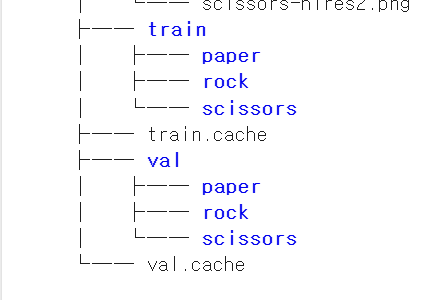

In [ ]:
# 에포크수는 알아서 조절
!yolo classify train data=/content/rock-paper-scissors model=yolo11s-cls epochs=50

Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11s-cls, data=/content/rock-paper-scissors, epochs=50, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_